
# <div style="padding:18px;color:white;margin:0;font-size:38px;text-align:center;display:fill;border-radius:20px;background-color:#4477AA;overflow:hidden">Skin Cancer Detection CNN</div>


# <div style="padding:18px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:20px;background-color:#4477AA;overflow:hidden">1 | Importing Libraries</div>

In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline



import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import glob
import cv2
import PIL
import shutil
import glob
from keras.utils import to_categorical
from tensorflow.random import set_seed
set_seed(42)
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

2024-05-08 17:17:39.793068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 17:17:39.793149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 17:17:39.795268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [64]:
# Set Matplotlib defaults
sns.set_style('darkgrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=25,
    titlepad=10,
)


# <div style="padding:18px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:20px;background-color:#4477AA;overflow:hidden">2 | Image Preprocessing</div>

In [3]:
print(os.listdir("../input"))

['melanoma-cancer-dataset']


In [4]:
MAIN = "../input/melanoma-cancer-dataset"

In [5]:
# Get the list of subdirectories in the main directory
sub = os.listdir(MAIN)
print(sub)

['test', 'train']


In [6]:
# Define paths to the  training and test directories
train_dir = '/kaggle/input/melanoma-cancer-dataset/train'
test_dir = '/kaggle/input/melanoma-cancer-dataset/test'

In [7]:
# Get the list of subdirectories in the training directory
subdirectories = os.listdir(train_dir)

In [8]:
subdirectories

['Benign', 'Malignant']

In [9]:
# Get the path to the sub-directories
Benign_dir = '/kaggle/input/melanoma-cancer-dataset/train/Benign'
Malignant_dir = '/kaggle/input/melanoma-cancer-dataset/train/Malignant'


In [10]:
def create_dataframe_from_directories(benign_dir, malignant_dir):
    """
    Creates a Pandas DataFrame with image paths and labels from two directories.

    Args:
        benign_dir (str): Path to the directory containing benign images.
        malignant_dir (str): Path to the directory containing malignant images.

    Returns:
        pandas.DataFrame: A DataFrame with columns 'image_path' and 'label'.
    """

    data = []

    # Add benign images with label 0
    for filename in os.listdir(benign_dir):
        data.append({'image_path': os.path.join(benign_dir, filename), 'label': 'Benign'})

    # Add malignant images with label 1
    for filename in os.listdir(malignant_dir):
        data.append({'image_path': os.path.join(malignant_dir, filename), 'label': 'Malignent'})

    df = pd.DataFrame(data)
    return df



In [11]:
df = create_dataframe_from_directories(Benign_dir, Malignant_dir)

In [12]:
df.head()

image_path   label
0  /kaggle/input/melanoma-cancer-dataset/train/Be...  Benign
1  /kaggle/input/melanoma-cancer-dataset/train/Be...  Benign
2  /kaggle/input/melanoma-cancer-dataset/train/Be...  Benign
3  /kaggle/input/melanoma-cancer-dataset/train/Be...  Benign
4  /kaggle/input/melanoma-cancer-dataset/train/Be...  Benign

In [13]:
df.shape

(11879, 2)

In [15]:
# The training set is too large, we will be using 30% of it
df0, dataset = train_test_split(df, test_size=0.3, random_state=42)

In [16]:
# Split the training set into training and validation sets
train_set, validation_set = train_test_split(dataset, test_size=0.3, random_state=42)

In [17]:
print(train_set.shape)
print(validation_set.shape)

(2494, 2)
(1070, 2)


In [44]:
# Get the path to the sub-directories
test_Benign_dir = '/kaggle/input/melanoma-cancer-dataset/test/Benign'
test_Malignant_dir = '/kaggle/input/melanoma-cancer-dataset/test/Malignant'

In [51]:
test_df = create_dataframe_from_directories(test_Benign_dir, test_Malignant_dir)

In [67]:
# The training set is too large, we will be using 30% of it
df0, test_df = train_test_split(test_df, test_size=0.3, random_state=42)

In [68]:
test_df.shape

(600, 2)

In [52]:
test_df.head()

image_path   label
0  /kaggle/input/melanoma-cancer-dataset/test/Ben...  Benign
1  /kaggle/input/melanoma-cancer-dataset/test/Ben...  Benign
2  /kaggle/input/melanoma-cancer-dataset/test/Ben...  Benign
3  /kaggle/input/melanoma-cancer-dataset/test/Ben...  Benign
4  /kaggle/input/melanoma-cancer-dataset/test/Ben...  Benign

In [48]:
test_df.shape

(2000, 2)


# <div style="padding:18px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:20px;background-color:#4477AA;overflow:hidden">3 | Images EDA</div>

In [18]:
train_class_count = train_set['label'].value_counts()
print(train_class_count)


label
Benign       1333
Malignent    1161
Name: count, dtype: int64


In [19]:
valid_class_count = validation_set['label'].value_counts()
print(valid_class_count)

label
Benign       566
Malignent    504
Name: count, dtype: int64


In [54]:
test_class_count = test_df['label'].value_counts()
print(test_class_count)

label
Benign       1000
Malignent    1000
Name: count, dtype: int64


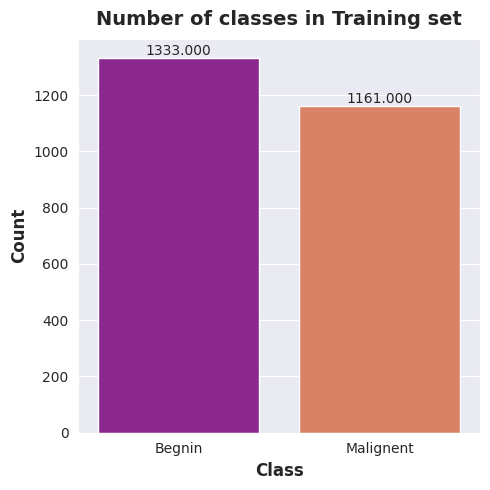

In [22]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=train_class_count.index, y=train_class_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of classes in Training set', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_class_count.index)), ['Begnin','Malignent'])
plt.show()

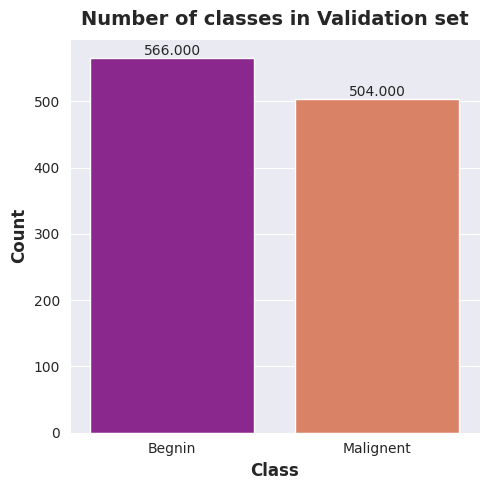

In [23]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=valid_class_count.index, y=valid_class_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of classes in Validation set', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(valid_class_count.index)), ['Begnin','Malignent'])
plt.show()

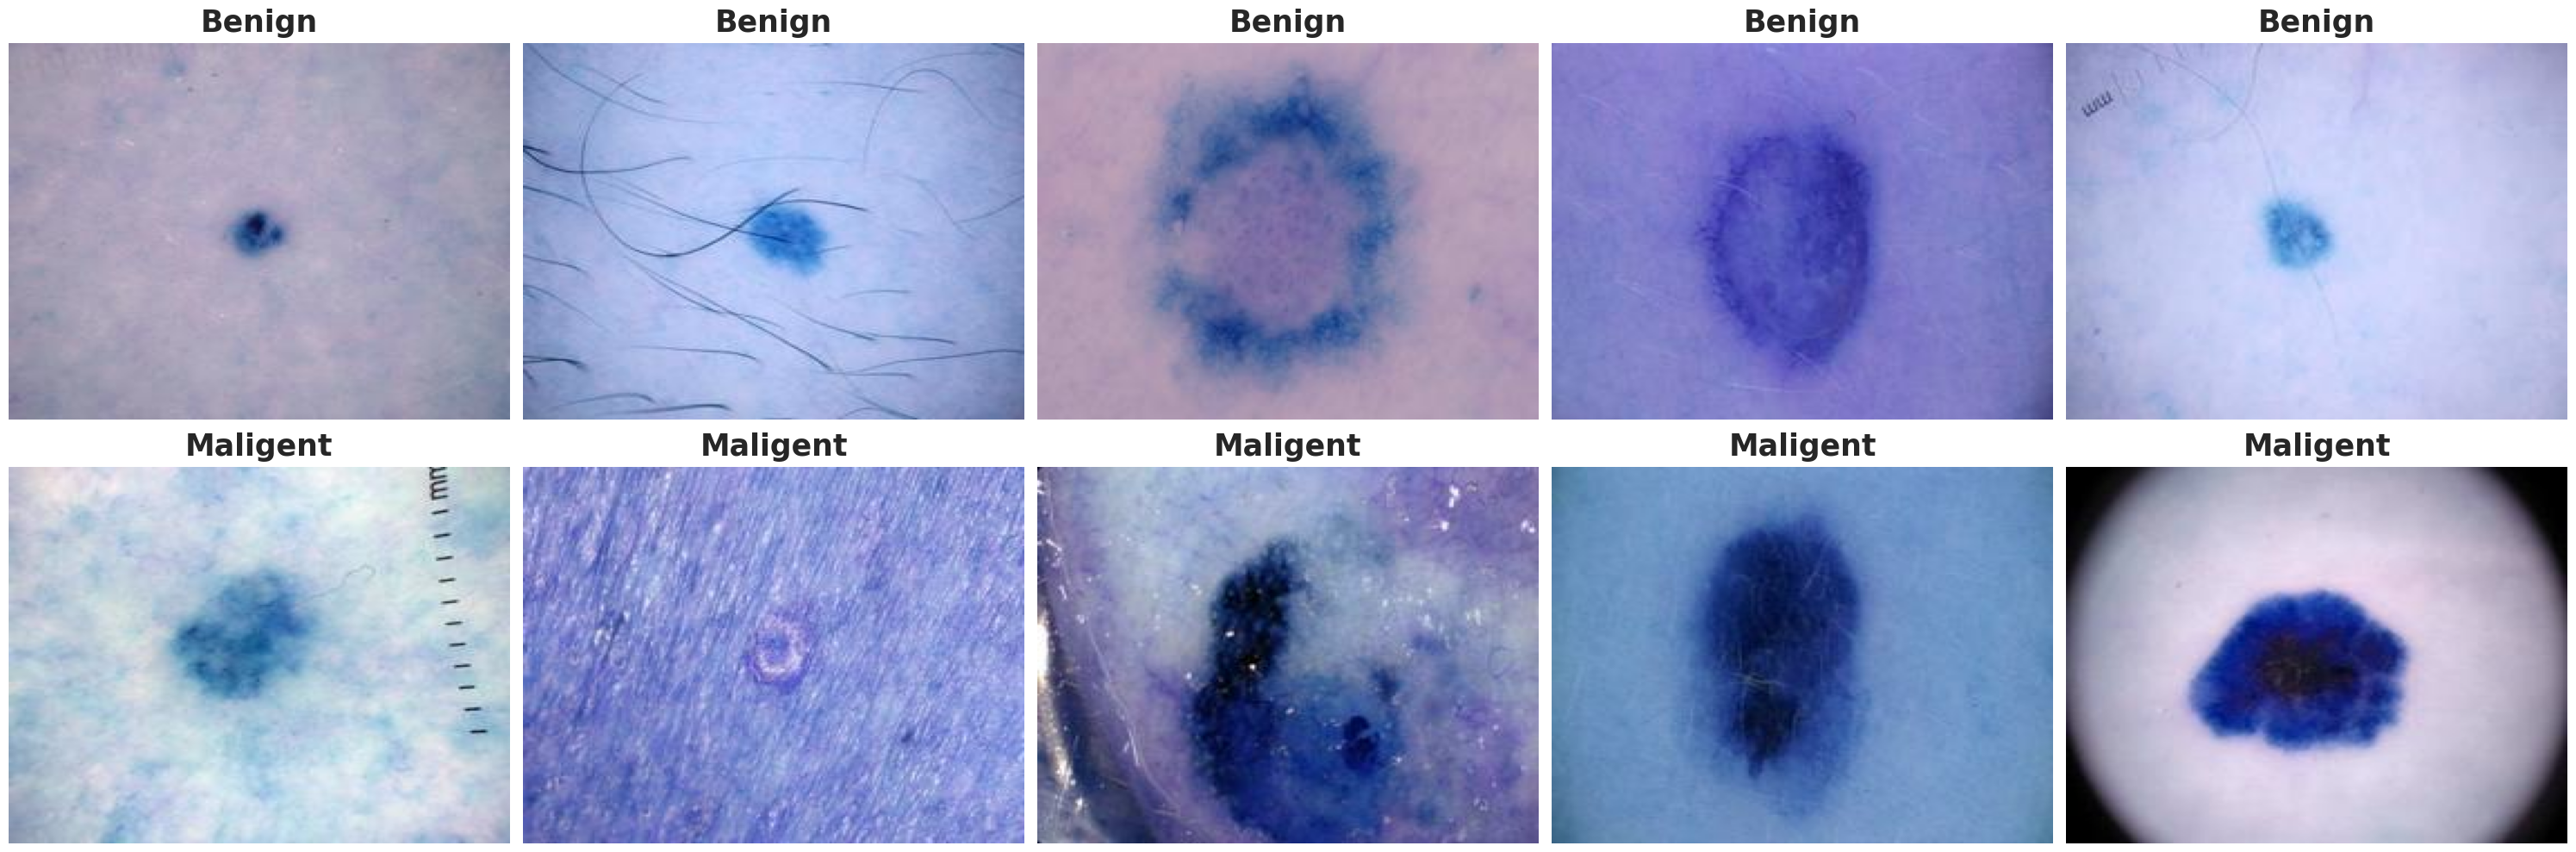

In [25]:
# Get few samples for both the classes
Benign_samples = (train_set[train_set['label']=='Benign']['image_path'].iloc[:5]).tolist()
Maligent_samples = (train_set[train_set['label']=='Malignent']['image_path'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Benign_samples + Maligent_samples
del Benign_samples ,Maligent_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img)
    if i<5:
        ax[i//5, i%5].set_title("Benign")
    else:
        ax[i//5, i%5].set_title("Maligent")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

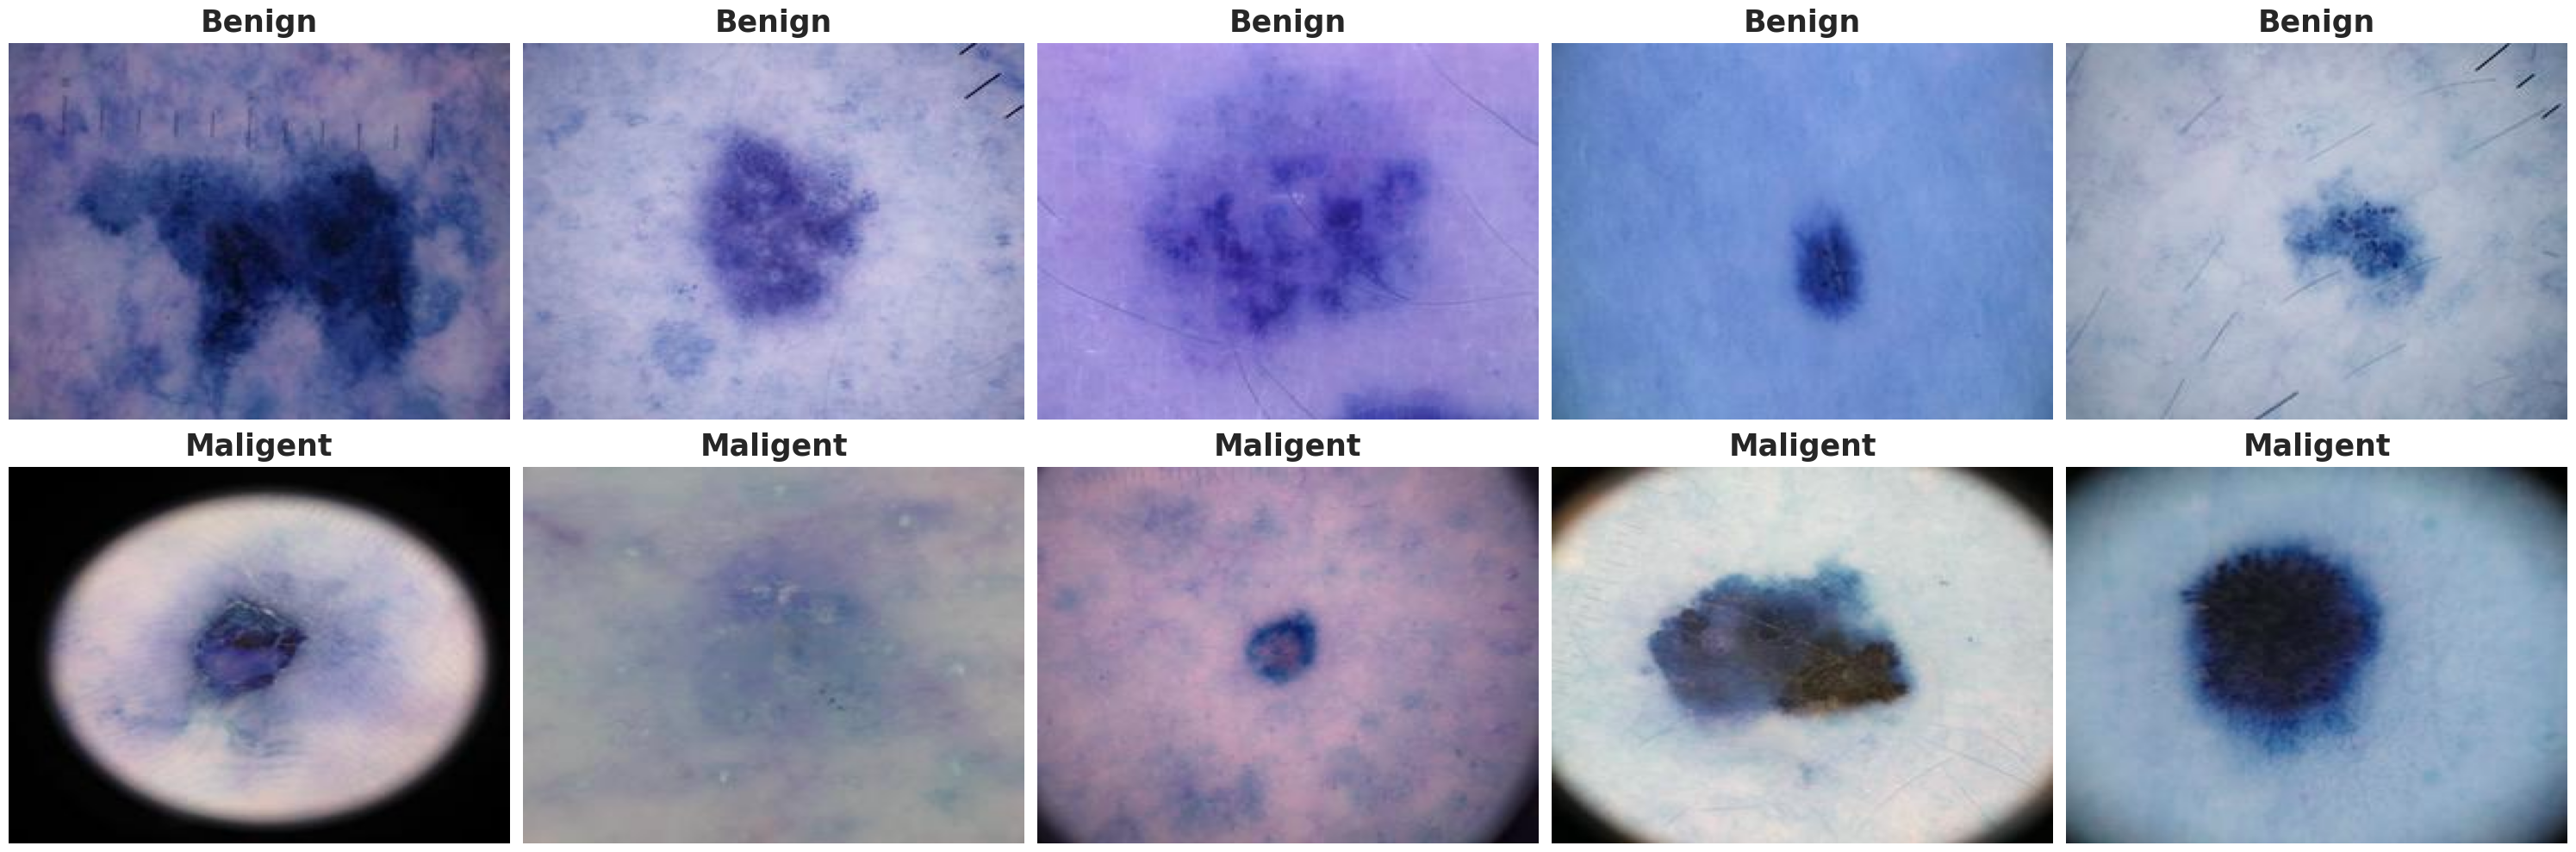

In [28]:
# Get few samples for both the classes
Benign_samples = (validation_set[validation_set['label']=='Benign']['image_path'].iloc[:5]).tolist()
Maligent_samples = (validation_set[validation_set['label']=='Malignent']['image_path'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Benign_samples + Maligent_samples
del Benign_samples ,Maligent_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img)
    if i<5:
        ax[i//5, i%5].set_title("Benign")
    else:
        ax[i//5, i%5].set_title("Maligent")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

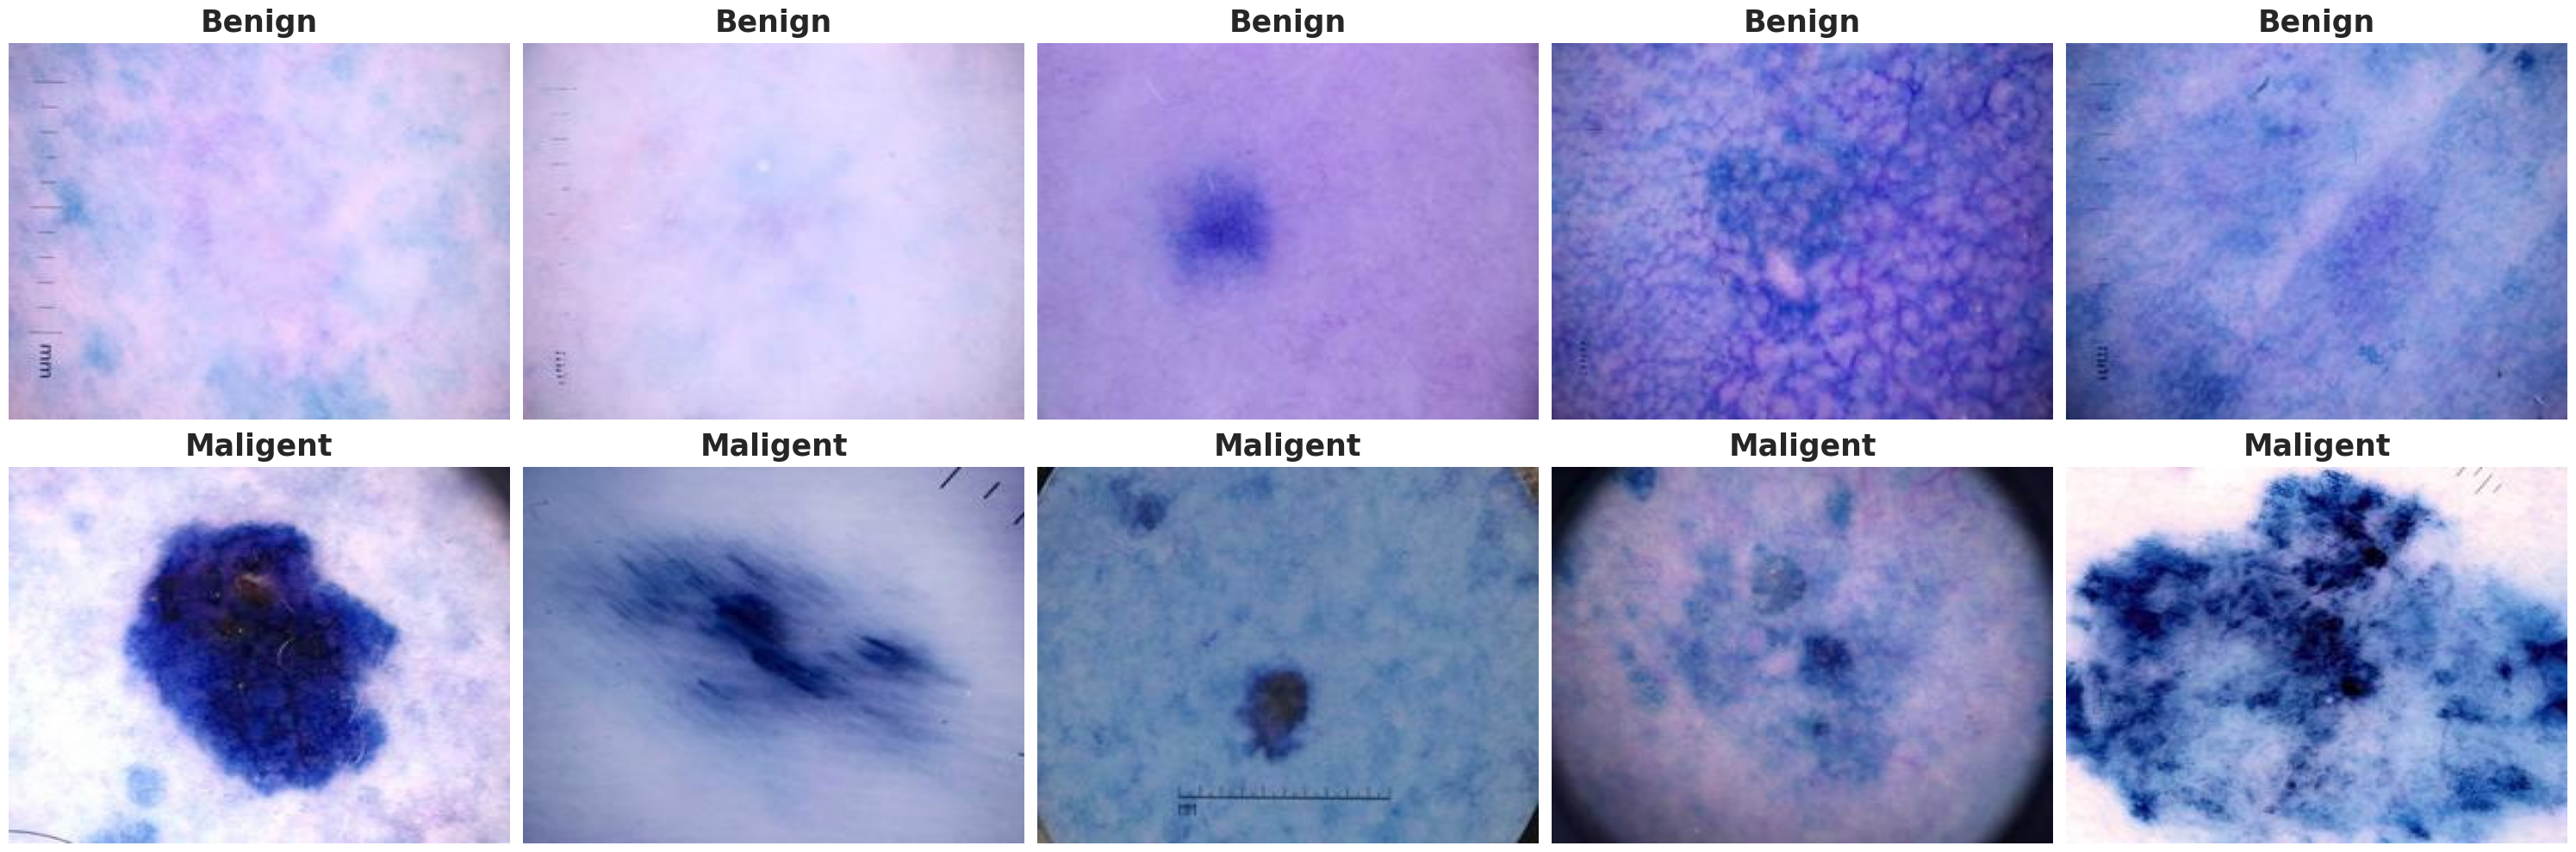

In [65]:
# Get few samples for both the classes
Benign_samples = (test_df[test_df['label']=='Benign']['image_path'].iloc[:5]).tolist()
Maligent_samples = (test_df[test_df['label']=='Malignent']['image_path'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Benign_samples + Maligent_samples
del Benign_samples ,Maligent_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img)
    if i<5:
        ax[i//5, i%5].set_title("Benign")
    else:
        ax[i//5, i%5].set_title("Maligent")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [29]:
img_width, img_height = 224, 224
batch_size = 32
epochs = 12


datagen = ImageDataGenerator(rescale=1.0 / 255)
#validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
#test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_dataframe(
    train_set,
    x_col = 'image_path',
    y_col = 'label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)
validation_generator = datagen.flow_from_dataframe(
    validation_set,
    x_col = 'image_path',
    y_col = 'label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2494 validated image filenames belonging to 2 classes.
Found 1070 validated image filenames belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [69]:
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 600 validated image filenames belonging to 2 classes.



# <div style="padding:18px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:20px;background-color:#4477AA;overflow:hidden">4 | CNN</div>

In [30]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,980,353 (339.43 MB)

 Trainable params: 88,978,433 (339.43 MB)

 Non-trainable params: 1,920 (7.50 KB)


# <div style="padding:18px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:20px;background-color:#4477AA;overflow:hidden">5 | Model Training</div>

In [31]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 695s 9s/step - accuracy: 0.7632 - loss: 3.4934 - val_accuracy: 0.5290 - val_loss: 3.1323
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 689s 9s/step - accuracy: 0.8200 - loss: 2.4621 - val_accuracy: 0.6346 - val_loss: 1.9558
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 692s 9s/step - accuracy: 0.8219 - loss: 1.6215 - val_accuracy: 0.7486 - val_loss: 1.3816
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 692s 9s/step - accuracy: 0.8299 - loss: 1.1871 - val_accuracy: 0.7981 - val_loss: 1.0594
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 693s 9s/step - accuracy: 0.8436 - loss: 0.8989 - val_accuracy: 0.7860 - val_loss: 0.9225
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 693s 9s/step - accuracy: 0.8401 - loss: 0.7576 - val_accuracy: 0.7991 - val_loss: 0.7554
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 691s 9s/step - accuracy: 0.8447 - loss: 0.6574 - val_accuracy: 0.8467 - val_loss: 0.6693
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 691s 9s/step - accuracy: 0.8212 - loss: 0.6475 - val_accuracy: 0.6561 - v

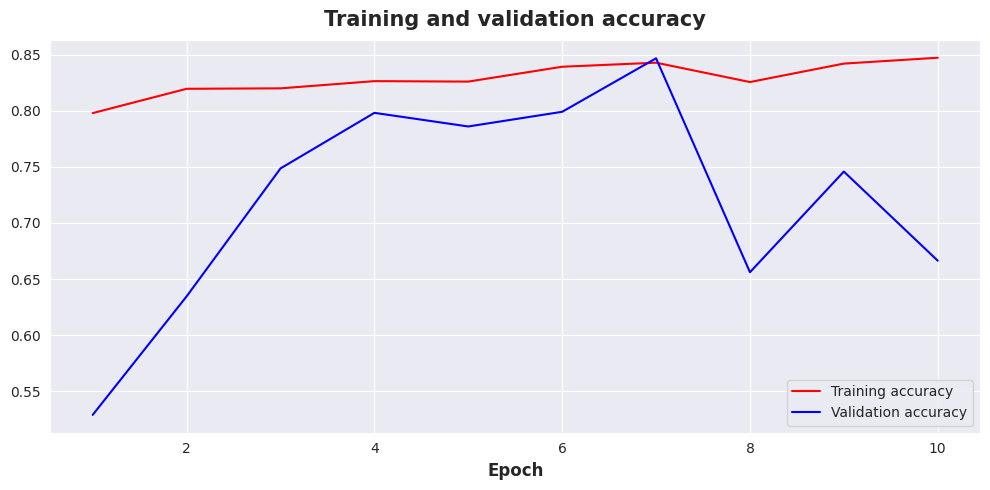

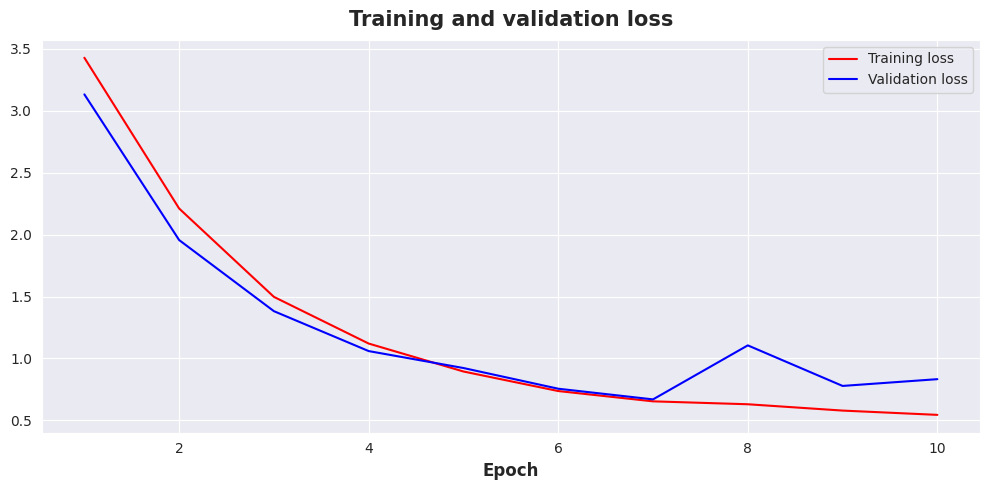

In [37]:
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy',)
plt.legend()
ax.set_xlabel("Epoch")
ax.tick_params()
plt.show()
#loss
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', )
plt.legend()
ax.set_xlabel("Epoch", )
ax.tick_params()
plt.show()

In [70]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8516 - loss: 0.6556
Test Accuracy: 0.8533333539962769
